<a href="https://colab.research.google.com/github/naman065/EE-655-/blob/main/EE655_ASSN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install -q scikit-image scikit-learn

# Download the MNIST-JPG dataset
!git clone https://github.com/teavanist/MNIST-JPG.git

# Import libraries
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


Cloning into 'MNIST-JPG'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 29 (delta 7), reused 27 (delta 7), pack-reused 1 (from 1)
Receiving objects: 100% (29/29), 17.53 MiB | 8.71 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [2]:
import zipfile

# Path to the downloaded zip file
zip_path = "MNIST-JPG/MNIST Dataset JPG format.zip"

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("MNIST-JPG")  # Extract to the MNIST-JPG folder



In [ ]:
# Define function to extract HOG features
def extract_hog_features(image):
    features, _ = hog(image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(3, 3), visualize=True)
    return features

# Load images and labels
def load_data(data_dir):
    images, labels = [], []
    for label in os.listdir(data_dir):
        folder = os.path.join(data_dir, label)
        for file in os.listdir(folder):
            filepath = os.path.join(folder, file)
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            img = cv2.resize(img, (28, 28))  # Resize to 28x28
            features = extract_hog_features(img)
            images.append(features)
            labels.append(int(label))
    return np.array(images), np.array(labels)

#
# Extract both training and testing data
train_data_dir = "/content/MNIST-JPG/MNIST Dataset JPG format/MNIST - JPG - training"  # Training data folder
test_data_dir = "/content/MNIST-JPG/MNIST Dataset JPG format/MNIST - JPG - testing"    # Testing data folder

# Load training data
X_train, y_train = load_data(train_data_dir)

# Load testing data
X_test, y_test = load_data(test_data_dir)

# Check dataset shapes
print(f"Training Data: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing Data: {X_test.shape}, Labels: {y_test.shape}")



Training Data: (60000, 81), Labels: (60000,)
Testing Data: (10000, 81), Labels: (10000,)


In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 95.39%


In [ ]:
from sklearn import svm
model = svm.SVC(kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 95.59%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 95.85%


In [3]:
import os
import cv2
import numpy as np

# Computing gradients
def compute_gradients(image):
    # Sobel kernels for gradients
    gx_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    gy_kernel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Convolving the image with kernels
    gx = cv2.filter2D(image, -1, gx_kernel)
    gy = cv2.filter2D(image, -1, gy_kernel)

    # Computing magnitude and angle
    magnitude = np.sqrt(gx**2 + gy**2)
    angle = np.arctan2(gy, gx) * (180 / np.pi)  # Convert to degrees
    angle[angle < 0] += 180  # Make angles positive
    return magnitude, angle


In [10]:
def extract_hog_features_manual(image, cell_size=8, block_size=3, bins=15):
    # Step 1: Computing  gradients
    magnitude, angle = compute_gradients(image)

    # Step 2: Dividing the image into cells
    h, w = image.shape
    cell_rows, cell_cols = h // cell_size, w // cell_size
    histograms = np.zeros((cell_rows, cell_cols, bins))

    for i in range(cell_rows):
        for j in range(cell_cols):
            # Extracting a cell
            cell_magnitude = magnitude[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]
            cell_angle = angle[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]

            # Creating histogram
            hist = np.zeros(bins)
            bin_width = 180 // bins

            for row in range(cell_size):
                for col in range(cell_size):
                    mag = cell_magnitude[row, col]
                    ang = cell_angle[row, col]

                    # Determine the bin
                    bin_idx = int(ang // bin_width) % bins
                    hist[bin_idx] += mag

            histograms[i, j] = hist


    block_stride = cell_size
    blocks = []
    for i in range(cell_rows - block_size + 1):
        for j in range(cell_cols - block_size + 1):
            block = histograms[i:i + block_size, j:j + block_size].ravel()
            block /= np.sqrt(np.sum(block ** 2) + 1e-6)
            blocks.append(block)

    return np.hstack(blocks)


In [11]:
# Load images and labels
def load_data(data_dir):
    images, labels = [], []
    for label in os.listdir(data_dir):
        folder = os.path.join(data_dir, label)
        for file in os.listdir(folder):
            filepath = os.path.join(folder, file)
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            img = cv2.resize(img, (28, 28))  # Resize to 28x28
            features = extract_hog_features_manual(img)
            images.append(features)
            labels.append(int(label))
    return np.array(images), np.array(labels)

#
# Extract both training and testing data
train_data_dir = "/content/MNIST-JPG/MNIST Dataset JPG format/MNIST - JPG - training"  # Training data folder
test_data_dir = "/content/MNIST-JPG/MNIST Dataset JPG format/MNIST - JPG - testing"    # Testing data folder

# Load training data
X_train, y_train = load_data(train_data_dir)

# Load testing data
X_test, y_test = load_data(test_data_dir)

# Check dataset shapes
print(f"Training Data: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing Data: {X_test.shape}, Labels: {y_test.shape}")

Training Data: (60000, 135), Labels: (60000,)
Testing Data: (10000, 135), Labels: (10000,)


In [12]:

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 78.15%


In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 76.54%


In [14]:
from sklearn import svm
model = svm.SVC(kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 80.80%


In [17]:
from skimage.feature import hog
import matplotlib.pyplot as plt

# Updated HOG feature extraction function
def extract_hog_with_visualization(image):
    features, hog_image = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,

    )
    return features, hog_image


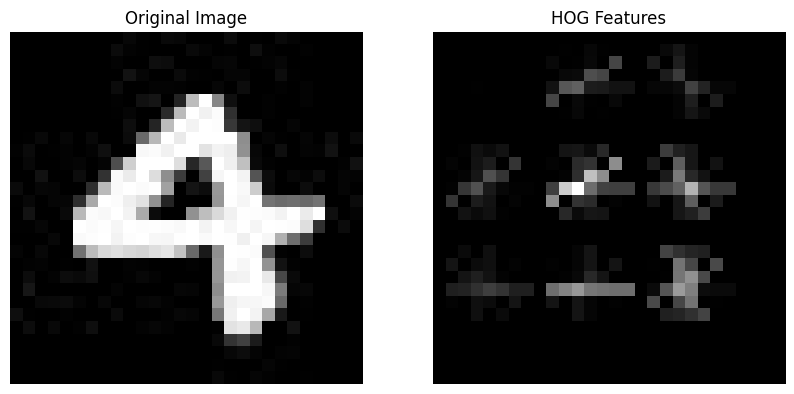

In [28]:
# Load a sample image (e.g., the first image from the training set)
sample_image_path = os.path.join(train_data_dir, os.listdir(train_data_dir)[1], os.listdir(os.path.join(train_data_dir, os.listdir(train_data_dir)[1]))[1])
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
sample_image = cv2.resize(sample_image, (28, 28))  # Resize to 28x28

# Extract HOG features and visualization
_, hog_visualization = extract_hog_with_visualization(sample_image)

# Display the original and HOG visualization side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(sample_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("HOG Features")
plt.imshow(hog_visualization, cmap="gray")
plt.axis("off")

plt.show()
